In [2]:
#library required
# import psycopg2

# from sqlalchemy import create_engine
# from sqlalchemy import text
import os
import time 
from datetime import datetime
import io 
import sys

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



In [3]:
# Read the CSV file into a DataFrame
df_bh_us = pd.read_csv("C:/Users/Poovesh Kumar M/Downloads/Planning/1_Data/df_bh_us_22_08_24.csv")
df_bh_ca = pd.read_csv("C:/Users/Poovesh Kumar M/Downloads/Planning/1_Data/df_bh_ca_22_08_24.csv")
df_mp_us = pd.read_csv("C:/Users/Poovesh Kumar M/Downloads/Planning/1_Data/df_mp_us_22_08_24.csv")
df_mp_ca = pd.read_csv("C:/Users/Poovesh Kumar M/Downloads/Planning/1_Data/df_mp_ca_22_08_24.csv")


C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_14384\3105605346.py:2: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_bh_us = pd.read_csv("C:/Users/Poovesh Kumar M/Downloads/Planning/1_Data/df_bh_us_22_08_24.csv")
C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_14384\3105605346.py:4: DtypeWarning: Columns (13,15,16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mp_us = pd.read_csv("C:/Users/Poovesh Kumar M/Downloads/Planning/1_Data/df_mp_us_22_08_24.csv")


In [4]:
# creating input df
df_bs1 = df_mp_us #chnage to load the df 


# Display the first few rows of the filtered DataFrame
print(df_bs1.head())


# Step 2: Create a list of distinct 'brand' and 'sales_channel' combinations
brands_channel_list = [f"{brand.replace('.', '_')}_{channel.replace('.', '_')}" 
                       for brand, channel in df_bs1[['brand', 'sales_channel']].drop_duplicates().values]

# Step 3: Convert the list to a single string, separated by commas
brands_channel_str = ', '.join(brands_channel_list)

# Display the combined string
print(brands_channel_str)

           brand sales_channel  sales_date sale_month_year        asin  \
0  majestic pure    Amazon.com  2024-07-28         07-2024  B06XCCVDH7   
1  majestic pure    Amazon.com  2024-07-24         07-2024  B06XCCVDH7   
2  majestic pure    Amazon.com  2024-07-20         07-2024  B06XCCVDH7   
3  majestic pure    Amazon.com  2024-07-16         07-2024  B06XCCVDH7   
4  majestic pure    Amazon.com  2024-07-12         07-2024  B06XCCVDH7   

  earliest_date_brand_channel earliest_date currency       asp  gmv_units  \
0                  2022-10-01    2024-07-28      USD  14.99000          7   
1                  2022-10-01    2024-07-24      USD  14.99000          6   
2                  2022-10-01    2024-07-20      USD  14.99000          2   
3                  2022-10-01    2024-07-16      USD  15.15125          8   
4                  2022-10-01    2024-07-12      USD  14.99000          6   

   ...  ad_spend  inventory_available      category sub_category  \
0  ...  3.118138        

In [5]:
#creating New DF 
df_bs2 = df_bs1
# Display the first few rows of the filtered DataFrame
print(df_bs2.head())

#creating ASINx VB for mapping purpose
# Remove rows where 'asin' is null
df_asin_vb = df_bs2.dropna(subset=['asin'])

# Select distinct 'asin' and 'velocity_bucket' combinations
df_asin_vb = df_asin_vb[['asin', 'velocity_bucket']].drop_duplicates()

# Display the resulting DataFrame
print("Distinct asin x velocity_bucket:")
print(df_asin_vb.head())

           brand sales_channel  sales_date sale_month_year        asin  \
0  majestic pure    Amazon.com  2024-07-28         07-2024  B06XCCVDH7   
1  majestic pure    Amazon.com  2024-07-24         07-2024  B06XCCVDH7   
2  majestic pure    Amazon.com  2024-07-20         07-2024  B06XCCVDH7   
3  majestic pure    Amazon.com  2024-07-16         07-2024  B06XCCVDH7   
4  majestic pure    Amazon.com  2024-07-12         07-2024  B06XCCVDH7   

  earliest_date_brand_channel earliest_date currency       asp  gmv_units  \
0                  2022-10-01    2024-07-28      USD  14.99000          7   
1                  2022-10-01    2024-07-24      USD  14.99000          6   
2                  2022-10-01    2024-07-20      USD  14.99000          2   
3                  2022-10-01    2024-07-16      USD  15.15125          8   
4                  2022-10-01    2024-07-12      USD  14.99000          6   

   ...  ad_spend  inventory_available      category sub_category  \
0  ...  3.118138        

In [6]:
# Check for asin Mapped to Multiple velocity_bucket Values
# Group by 'asin' and count the number of unique 'velocity_bucket' values
asin_multiple_vb = df_asin_vb.groupby('asin')['velocity_bucket'].nunique()

# Filter to find asins that are mapped to more than one velocity_bucket
asin_with_multiple_vb = asin_multiple_vb[asin_multiple_vb > 1]

print("ASINs mapped to multiple velocity buckets:")
print(asin_with_multiple_vb)

# # Group by 'velocity_bucket' and count the number of unique 'asin' values
# vb_multiple_asin = df_asin_vb.groupby('velocity_bucket')['asin'].nunique()

# # Filter to find velocity_buckets that are mapped to more than one asin
# vb_with_multiple_asin = vb_multiple_asin[vb_multiple_asin > 1]

# print("Velocity buckets mapped to multiple ASINs:")
# print(vb_with_multiple_asin)

ASINs mapped to multiple velocity buckets:
Series([], Name: velocity_bucket, dtype: int64)


In [7]:
df_monthly

NameError: name 'df_monthly' is not defined

In [8]:
# Rolling up data - month level

# Convert 'sales_date' to datetime format if it isn't already
df_bs2['sales_date'] = pd.to_datetime(df_bs2['sales_date'])

# Extract year and month, set the day to '01', and then convert to date
df_bs2['year_month'] = df_bs2['sales_date'].dt.to_period('M').dt.to_timestamp().dt.date

# Group by 'asin' and 'year_month' to summarize 'gmv_units'
df_monthly = df_bs2.groupby(['asin', 'year_month'], as_index=False)['gmv_units'].sum()

print("Monthly summarized data:")
print(df_monthly.head())

# Pivot the monthly data to have 'asin' in rows and 'year_month' in columns
df_pivot_month = df_monthly.pivot(index='asin', columns='year_month', values='gmv_units').fillna(0)

# Reset index to make 'asin' a column
df_pivot_month.reset_index(inplace=True)

print("Pivoted data:")
print(df_pivot_month.head())


Monthly summarized data:
         asin  year_month  gmv_units
0  B00PMR3QF2  2022-10-01       6677
1  B00PMR3QF2  2022-11-01       8798
2  B00PMR3QF2  2022-12-01      13195
3  B00PMR3QF2  2023-01-01      10993
4  B00PMR3QF2  2023-02-01       9855
Pivoted data:
year_month        asin  2022-10-01  2022-11-01  2022-12-01  2023-01-01  \
0           B00PMR3QF2      6677.0      8798.0     13195.0     10993.0   
1           B00PV15BPW     10923.0      8295.0      6511.0      5384.0   
2           B00Q7Z1UZ6         0.0         0.0         0.0         0.0   
3           B00Q96XGUU        92.0       131.0        79.0        50.0   
4           B00QR6SS6O      2537.0      2309.0      2579.0      3262.0   

year_month  2023-02-01  2023-03-01  2023-04-01  2023-05-01  2023-06-01  ...  \
0               9855.0     11715.0     11192.0     10334.0     11026.0  ...   
1               4782.0      6399.0      7346.0      7147.0      9422.0  ...   
2                  0.0         0.0         0.0         0.

In [9]:
# Removing Outlier (IQR)

# Select the required columns from the original DataFrame
df_bs3 = df_monthly[['year_month', 'asin', 'gmv_units']]

# Define a function to remove outliers for each 'asin'
def remove_outliers(group):
    Q1 = group['gmv_units'].quantile(0.25)
    Q3 = group['gmv_units'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['gmv_units'] >= lower_bound) & (group['gmv_units'] <= upper_bound)]

# Apply the function to remove outliers for each 'asin'
df_bs3_no_outliers = df_bs3.groupby('asin').apply(remove_outliers).reset_index(drop=True)

# Display the DataFrame after removing outliers
print("DataFrame after removing outliers:")
print(df_bs3_no_outliers)


DataFrame after removing outliers:
      year_month        asin  gmv_units
0     2022-10-01  B00PMR3QF2       6677
1     2022-11-01  B00PMR3QF2       8798
2     2022-12-01  B00PMR3QF2      13195
3     2023-01-01  B00PMR3QF2      10993
4     2023-02-01  B00PMR3QF2       9855
...          ...         ...        ...
6175  2024-06-01  B0D7HZR4XL          0
6176  2024-07-01  B0D7HZR4XL          1
6177  2024-06-01  B0D811N8HV          0
6178  2024-07-01  B0D811N8HV        113
6179  2024-07-01  B0D8HVYNM8          0

[6180 rows x 3 columns]


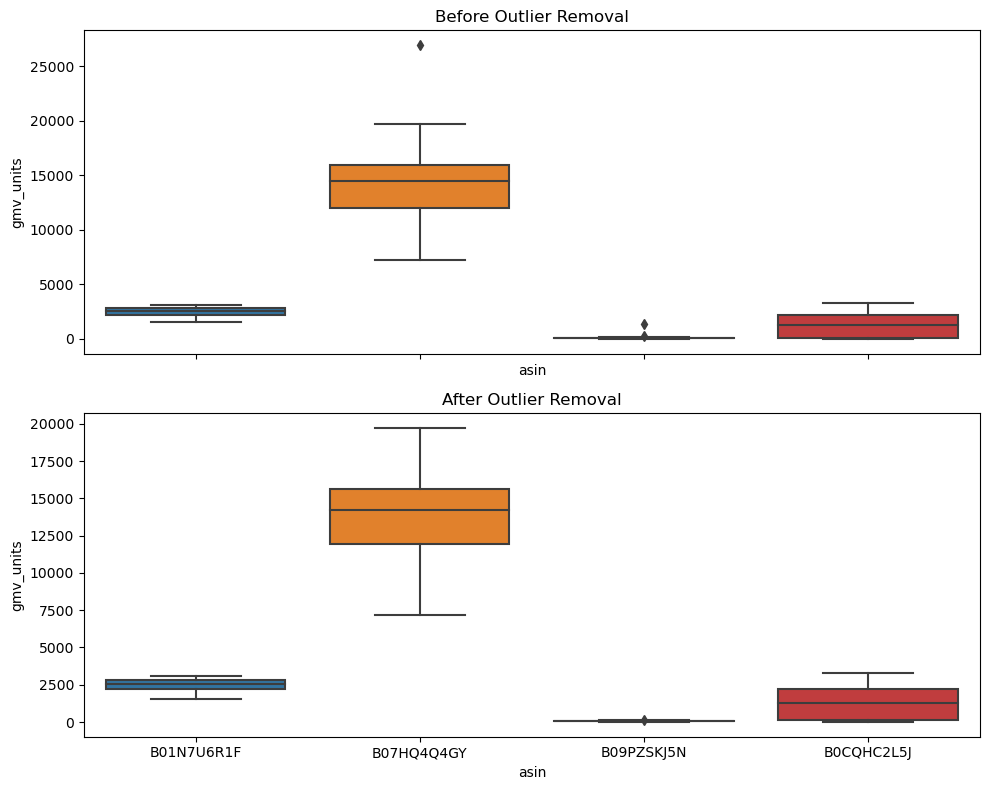

In [10]:
#Visualisation - Removing Outlier
#Visualisation of sample asin's - Box plot user input 

# Define the list of 'asin' values to visualize (replace with your own list)
sample_asins = ['B07HQ4Q4GY','B01N7U6R1F', 'B0CQHC2L5J', 'B09PZSKJ5N']  # Replace these with actual ASINs

# Filter the original and outlier-removed DataFrames for the selected 'asin' values
df_sample_before = df_monthly[df_monthly['asin'].isin(sample_asins)]
df_sample_after = df_bs3_no_outliers[df_bs3_no_outliers['asin'].isin(sample_asins)]

# Set up the figure and axes
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot the data before outlier removal
sns.boxplot(x='asin', y='gmv_units', data=df_sample_before, ax=axes[0])
axes[0].set_title('Before Outlier Removal')

# Plot the data after outlier removal
sns.boxplot(x='asin', y='gmv_units', data=df_sample_after, ax=axes[1])
axes[1].set_title('After Outlier Removal')

# Display the plots
plt.tight_layout()
plt.show()

C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_14384\4049373984.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample_before['year_month'] = pd.to_datetime(df_sample_before['year_month'])
C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_14384\4049373984.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample_after['year_month'] = pd.to_datetime(df_sample_after['year_month'])


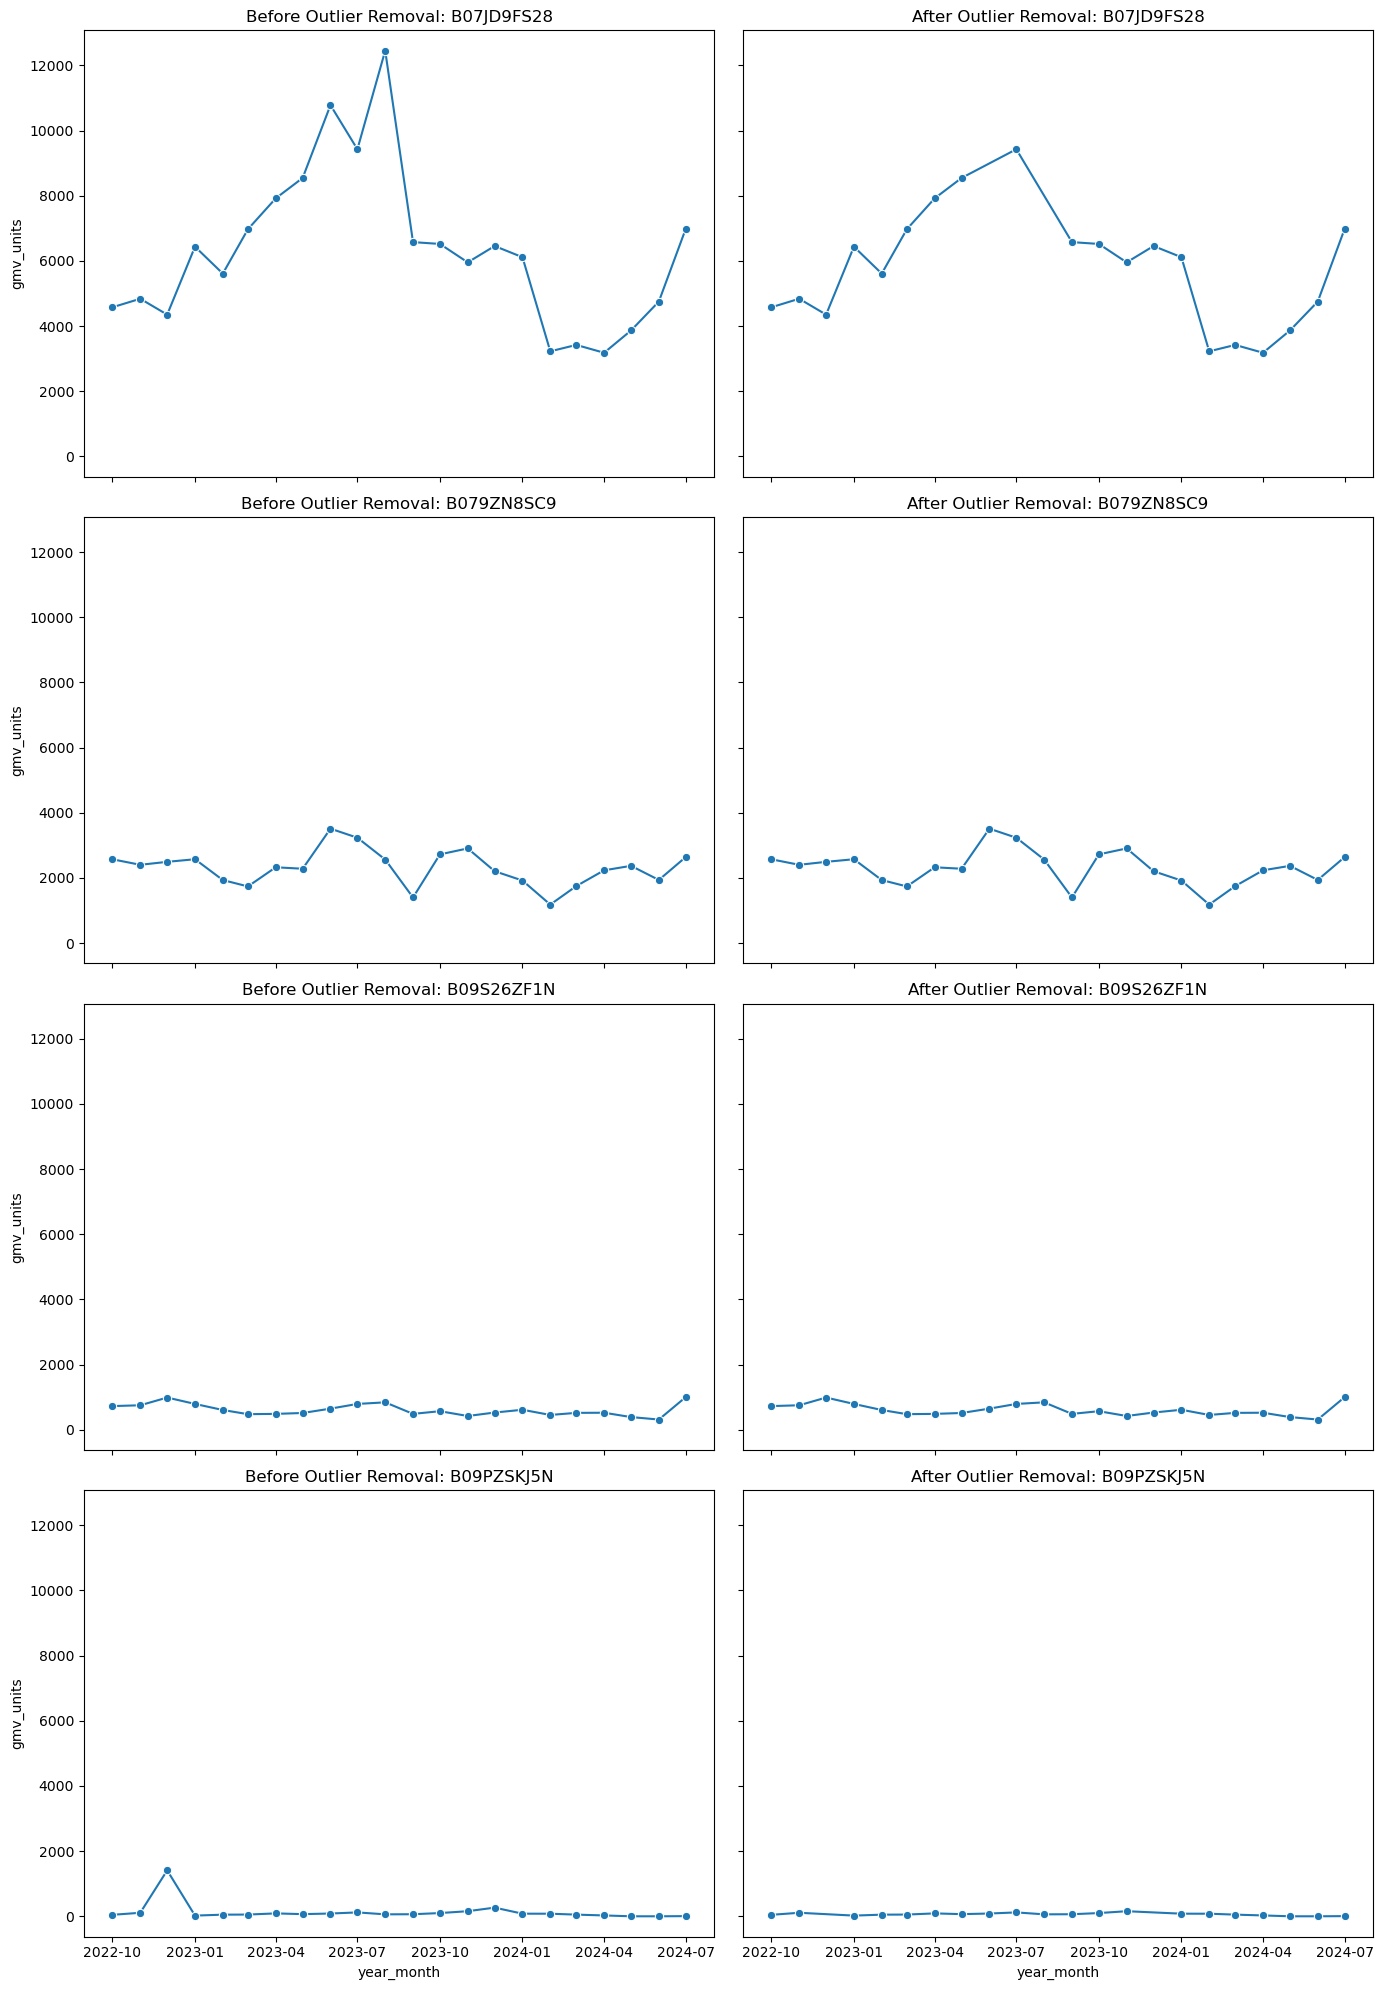

In [11]:
#Visualisation - Removing Outlier
#Visualisation of sample asin's - line chart user input 
# Define the list of 'asin' values to visualize
sample_asins = ['B07JD9FS28', 'B079ZN8SC9', 'B09S26ZF1N', 'B09PZSKJ5N']  # Replace with actual ASINs

# Filter the original and outlier-removed DataFrames for the selected 'asin' values
df_sample_before = df_monthly[df_monthly['asin'].isin(sample_asins)]
df_sample_after = df_bs3_no_outliers[df_bs3_no_outliers['asin'].isin(sample_asins)]

# Convert 'sales_date' to datetime if it's not already
df_sample_before['year_month'] = pd.to_datetime(df_sample_before['year_month'])
df_sample_after['year_month'] = pd.to_datetime(df_sample_after['year_month'])

# Set up the figure and axes
fig, axes = plt.subplots(len(sample_asins), 2, figsize=(14, len(sample_asins) * 5), sharex=True, sharey=True)

# Plot the data before outlier removal
for i, asin in enumerate(sample_asins):
    ax_before = axes[i, 0]
    ax_after = axes[i, 1]
    
    data_before = df_sample_before[df_sample_before['asin'] == asin]
    data_after = df_sample_after[df_sample_after['asin'] == asin]

    sns.lineplot(x='year_month', y='gmv_units', data=data_before, ax=ax_before, marker='o')
    sns.lineplot(x='year_month', y='gmv_units', data=data_after, ax=ax_after, marker='o')

    ax_before.set_title(f'Before Outlier Removal: {asin}')
    ax_after.set_title(f'After Outlier Removal: {asin}')

# Adjust layout
plt.tight_layout()
plt.show()


In [12]:
#Collecting Samples of ASINs vs Velocity Buckets vs monthly sales

# Assuming df_bs2 has 'asin' and 'velocity_bucket' columns
df_merged_month = df_asin_vb[['asin', 'velocity_bucket']].merge(df_pivot_month, on='asin', how='right')

# Reorder columns to have 'velocity_bucket', 'asin', and then the month-year columns
columns_order = ['velocity_bucket', 'asin'] + list(df_merged_month.columns[2:])
df_month = df_merged_month[columns_order]

# Replace null values in 'velocity_bucket' with a placeholder 'NULL'
df_month['velocity_bucket'] = df_month['velocity_bucket'].fillna('NULL')

# Define the custom order for velocity_bucket, using 'NULL' as the placeholder
custom_order = ['SF', 'F', 'M', 'SM', 'NULL']

# Convert 'velocity_bucket' to a categorical type with the custom order
df_month['velocity_bucket'] = pd.Categorical(df_month['velocity_bucket'], categories=custom_order, ordered=True)

# Sort the DataFrame by the custom order
df_month_sorted = df_month.sort_values(by='velocity_bucket').reset_index(drop=True)

# print("Final DataFrame:")
print("Final DataFrame sorted by velocity_bucket:")
print(df_month_sorted.head())

df_month_sorted.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/VB_ASIN_sales_month_year_'+brands_channel_str+'.csv')

Final DataFrame sorted by velocity_bucket:
  velocity_bucket        asin  2022-10-01  2022-11-01  2022-12-01  2023-01-01  \
0              SF  B00PMR3QF2      6677.0      8798.0     13195.0     10993.0   
1              SF  B00PV15BPW     10923.0      8295.0      6511.0      5384.0   
2              SF  B0C2Z44JLK         0.0         0.0         0.0         0.0   
3              SF  B07JD9FS28      4579.0      4840.0      4353.0      6438.0   
4              SF  B01BKB3C98      2551.0      2150.0      2988.0      3470.0   

   2023-02-01  2023-03-01  2023-04-01  2023-05-01  ...  2023-10-01  \
0      9855.0     11715.0     11192.0     10334.0  ...      8787.0   
1      4782.0      6399.0      7346.0      7147.0  ...     10849.0   
2         0.0         0.0         0.0         0.0  ...      2636.0   
3      5612.0      6974.0      7922.0      8547.0  ...      6522.0   
4      2274.0      3687.0      3718.0      3845.0  ...      3579.0   

   2023-11-01  2023-12-01  2024-01-01  2024-02-01

In [13]:
#Auto Arima Forecasting in Python
!pip install pmdarima

In [14]:
#Batches:

# df_monthly already exists and 'year_month' needs to be in datetime format
df_monthly['year_month'] = pd.to_datetime(df_monthly['year_month'])

# Manually specify the dates you're interested in removing
selected_dates = ['2024-05-01','2024-06-01', '2024-07-01']

# Convert the dates to datetime format
selected_dates = pd.to_datetime(selected_dates)

# Filter the DataFrame to exclude the selected dates
df_batch1 = df_monthly[~df_monthly['year_month'].isin(selected_dates)]

# Display the resulting DataFrame
print("Filtered DataFrame with selected dates removed:")
print(df_batch1)

df_batch1.tail()

Filtered DataFrame with selected dates removed:
            asin year_month  gmv_units
0     B00PMR3QF2 2022-10-01       6677
1     B00PMR3QF2 2022-11-01       8798
2     B00PMR3QF2 2022-12-01      13195
3     B00PMR3QF2 2023-01-01      10993
4     B00PMR3QF2 2023-02-01       9855
...          ...        ...        ...
6412  B0CQHC2L5J 2024-04-01        461
6416  B0CXDH2LPP 2024-04-01          0
6420  B0CXDHX2QN 2024-04-01          0
6424  B0CXDRY3WC 2024-04-01          0
6428  B0CXDSCVJB 2024-04-01          0

[5606 rows x 3 columns]


,asin,year_month,gmv_units
6412,B0CQHC2L5J,2024-04-01,461
6416,B0CXDH2LPP,2024-04-01,0
6420,B0CXDHX2QN,2024-04-01,0
6424,B0CXDRY3WC,2024-04-01,0
6428,B0CXDSCVJB,2024-04-01,0


#version 2 : selected ASIN list
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# Ensure 'year_month' is in datetime format
df_batch1['year_month'] = pd.to_datetime(df_batch1['year_month'])

# Set the 'year_month' column as the index
df_batch1.set_index('year_month', inplace=True)

# List of ASINs to forecast and plot
selected_asins = ['B07JD9FS28', 'B079ZN8SC9', 'B09S26ZF1N', 'B09PZSKJ5N']  # Replace with actual ASINs

# Initialize a dictionary to store the forecast results
forecast_results = {}

# Input start date for the forecast
start_date = pd.to_datetime('2024-06-01')  # Replace with your desired start date

# Loop through each ASIN and perform forecasting
for asin in selected_asins:
    # Filter the DataFrame for the current ASIN
    df_asin = df_batch1[df_batch1['asin'] == asin]

    # Build the Auto ARIMA model
    model = auto_arima(df_asin['gmv_units'], 
                       seasonal=False, 
                       trace=True, 
                       suppress_warnings=True)

    # Forecast for the next 6 months
    forecast, conf_int = model.predict(n_periods=6, return_conf_int=True)

    # Create a DataFrame for the current ASIN's forecasts
    date_range = pd.date_range(start=start_date, periods=6, freq='MS')
    forecast_df = pd.DataFrame({
        'ASIN': asin,
        'forecast': forecast,
        'lower_conf_int': conf_int[:, 0],
        'upper_conf_int': conf_int[:, 1],
        'forecast_date': date_range
    })

    # Append to the forecast results DataFrame
    forecast_results[asin] = forecast_df

# Concatenate all the individual ASIN forecast DataFrames
df_forecasts = pd.concat(forecast_results.values(), ignore_index=True)

# Save the forecast results to a CSV file
df_forecasts.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/forecast_results_selected_asin'+brands_channel_str+'.csv', index=False)

# Print part of the result
print(df_forecasts.head())

# Plot the results for each selected ASIN
plt.figure(figsize=(12, 8))

for asin in selected_asins:
    # Filter the actual data for the current ASIN
    df_asin = df_batch1[df_batch1['asin'] == asin]
    
    # Filter the forecast data for the current ASIN
    forecast_df = forecast_results[asin]
    forecast_dates = forecast_df['forecast_date']
    forecast_values = forecast_df['forecast']
    lower_conf_int = forecast_df['lower_conf_int']
    upper_conf_int = forecast_df['upper_conf_int']

    # Plot actual GMV units
    plt.plot(df_asin.index, df_asin['gmv_units'], label=f'Actual ({asin})')

    # Plot forecasted GMV units
    plt.plot(forecast_dates, forecast_values, label=f'Forecast ({asin})', marker='o', color='red')

    # Plot confidence interval
    plt.fill_between(forecast_dates, 
                     lower_conf_int, 
                     upper_conf_int, 
                     color='pink', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('GMV Units')
plt.title('GMV Units Forecast for Selected ASINs')
plt.legend()
plt.show()


In [15]:
# print(df_batch1.columns)
df_batch1

,asin,year_month,gmv_units
0,B00PMR3QF2,2022-10-01,6677
1,B00PMR3QF2,2022-11-01,8798
2,B00PMR3QF2,2022-12-01,13195
3,B00PMR3QF2,2023-01-01,10993
4,B00PMR3QF2,2023-02-01,9855
...,...,...,...
6412,B0CQHC2L5J,2024-04-01,461
6416,B0CXDH2LPP,2024-04-01,0
6420,B0CXDHX2QN,2024-04-01,0
6424,B0CXDRY3WC,2024-04-01,0


In [16]:
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# Ensure 'year_month' is in datetime format
df_batch1['year_month'] = pd.to_datetime(df_batch1['year_month'])

# List of ASINs to forecast and plot
selected_asins = df_batch1['asin'].unique()

# Initialize a dictionary to store the forecast results
forecast_results = {}

# Input start date for the forecast
start_date = pd.to_datetime('2024-05-01')  # Replace with your desired start date

# Loop through each ASIN and perform forecasting
for asin in selected_asins:
    # Filter the DataFrame for the current ASIN
    df_asin = df_batch1[df_batch1['asin'] == asin]
    
    if df_asin.empty:
        print(f"No data available for ASIN {asin}")
        continue

    if df_asin.shape[0] < 10:
        print(f"Not enough data for ASIN {asin} ({df_asin.shape[0]} data points)")
        continue

    if df_asin['gmv_units'].isnull().any():
        print(f"Missing values found for ASIN {asin}")
        continue

    # Build the Auto ARIMA model
    model = auto_arima(df_asin['gmv_units'], 
                       seasonal=False, 
                       trace=False, 
                       suppress_warnings=True)
    
    # Forecast for the next 6 months
    forecast, conf_int = model.predict(n_periods=6, return_conf_int=True)
    
    # Create a DataFrame for the current ASIN's forecasts
    date_range = pd.date_range(start=start_date, periods=6, freq='MS')
    forecast_df = pd.DataFrame({
        'ASIN': asin,
        'forecast': forecast,
        'lower_conf_int': conf_int[:, 0],
        'upper_conf_int': conf_int[:, 1],
        'forecast_date': date_range
    })
    
    # Append to the forecast results DataFrame
    forecast_results[asin] = forecast_df

# Concatenate all the individual ASIN forecast DataFrames
df_forecasts = pd.concat(forecast_results.values(), ignore_index=True)

# Save the forecast results to a CSV file
df_forecasts.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/forecast_results'+brands_channel_str+'.csv', index=False)

# Print part of the result
print(df_forecasts.head())

# # Plot the results for each selected ASIN
# plt.figure(figsize=(12, 8))

# for asin in selected_asins:
#     # Filter the actual data for the current ASIN
#     df_asin = df_batch1[df_batch1['asin'] == asin]
    
#     # Filter the forecast data for the current ASIN
#     forecast_df = forecast_results[asin]
#     forecast_dates = forecast_df['forecast_date']
#     forecast_values = forecast_df['forecast']
#     lower_conf_int = forecast_df['lower_conf_int']
#     upper_conf_int = forecast_df['upper_conf_int']

#     # Plot actual GMV units
#     plt.plot(df_asin['year_month'], df_asin['gmv_units'], label=f'Actual ({asin})')

#     # Plot forecasted GMV units
#     plt.plot(forecast_dates, forecast_values, label=f'Forecast ({asin})', marker='o', color='red')

#     # Plot confidence interval
#     plt.fill_between(forecast_dates, 
#                      lower_conf_int, 
#                      upper_conf_int, 
#                      color='pink', alpha=0.3)

# plt.xlabel('Date')
# plt.ylabel('GMV Units')
# plt.title('GMV Units Forecast for Selected ASINs')
# plt.legend()
# plt.show()


C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_14384\846030480.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch1['year_month'] = pd.to_datetime(df_batch1['year_month'])
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B00Q7Z1UZ6 (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B00QR7T8WQ (8 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B00UA2A0XK (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3

Not enough data for ASIN B00VXEQ0WO (6 data points)
Not enough data for ASIN B00VXIV1XI (6 data points)
Not enough data for ASIN B00WFXNXVI (6 data points)
Not enough data for ASIN B00WH2CKCA (6 data points)
Not enough data for ASIN B00WKTKBTY (7 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B00YQ93VPW (6 data points)
Not enough data for ASIN B00Z5WJIHO (6 data points)
Not enough data for ASIN B01057FM6E (6 data points)
Not enough data for ASIN B0105POI9I (6 data points)
Not enough data for ASIN B011NSRBY0 (6 data points)
Not enough data for ASIN B012UQJNMC (6 data points)
Not enough data for ASIN B014JFT9DU (6 data points)
Not enough data for ASIN B016H8ICBC (6 data points)
Not enough data for ASIN B016RQ8PRU (7 data points)
Not enough data for ASIN B01728CU8M (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B01745E4C8 (6 data points)
Not enough data for ASIN B01766QDTC (6 data points)
Not enough data for ASIN B01768QEPI (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B01771C9H6 (6 data points)
Not enough data for ASIN B0177J3BVG (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B017SLT8ME (6 data points)
Not enough data for ASIN B01BGIB81Y (6 data points)
Not enough data for ASIN B01BHO79V0 (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B01CHW4QOO (6 data points)
Not enough data for ASIN B01CKBJQCO (6 data points)
Not enough data for ASIN B01CO4EPQY (6 data points)
Not enough data for ASIN B01DV9H7Z2 (6 data points)
Not enough data for ASIN B01DVU2ZQW (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B01ERVKA3Y (6 data points)
Not enough data for ASIN B01FR1PYXE (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B01GHF9OXU (6 data points)
Not enough data for ASIN B01GZ6ZAVG (6 data points)
Not enough data for ASIN B01HCWXUIC (6 data points)
Not enough data for ASIN B01HIW5BG0 (6 data points)
Not enough data for ASIN B01HN30YAW (6 data points)
Not enough data for ASIN B01HSHKNC2 (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B01IIJI4TS (6 data points)
Not enough data for ASIN B01INZE248 (7 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B01IU1ZUNM (6 data points)
Not enough data for ASIN B01JLJGIEC (6 data points)
Not enough data for ASIN B01JRV494K (6 data points)
Not enough data for ASIN B01JRW3EJA (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B01K86X4HG (6 data points)
Not enough data for ASIN B01K8IJVWG (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B01K8XC1FU (6 data points)
Not enough data for ASIN B01K90KCP8 (6 data points)
Not enough data for ASIN B01K91YRTO (6 data points)
Not enough data for ASIN B01K93HIDO (6 data points)
Not enough data for ASIN B01KFENEXK (6 data points)
Not enough data for ASIN B01KW4Q6VU (6 data points)
Not enough data for ASIN B01KYFMHJC (6 data points)
Not enough data for ASIN B01LAHAQ2I (6 data points)
Not enough data for ASIN B01LAJP9LE (6 data points)
Not enough data for ASIN B01LDGNJHK (6 data points)
Not enough data for ASIN B01LMJQ53I (6 data points)
Not enough data for ASIN B01LW1N3YN (6 data points)
Not enough data for ASIN B01LWMTMIW (6 data points)
Not enough data for ASIN B01LWYNWIF (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B01LWYV0F3 (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B01LXMPA35 (6 data points)
Not enough data for ASIN B01LXY3G5B (6 data points)
Not enough data for ASIN B01LY9DCZ9 (6 data points)
Not enough data for ASIN B01LY9FZHH (6 data points)
Not enough data for ASIN B01LY9GFBF (6 data points)
Not enough data for ASIN B01LYKQRWH (6 data points)
Not enough data for ASIN B01LYR2KTP (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B01M12V5G3 (6 data points)
Not enough data for ASIN B01M1CJSZH (6 data points)
Not enough data for ASIN B01MQYUZ0C (6 data points)
Not enough data for ASIN B01MSEKDFX (6 data points)
Not enough data for ASIN B01MU29C2X (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B01MY4KYSG (6 data points)
Not enough data for ASIN B01MYA4Q1X (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B01N2W16I8 (6 data points)
Not enough data for ASIN B01N35XMUC (6 data points)
Not enough data for ASIN B01N3T69R3 (6 data points)
Not enough data for ASIN B01N6IHDIN (6 data points)
Not enough data for ASIN B01N6N716A (6 data points)
Not enough data for ASIN B01N7L0WA6 (6 data points)
Not enough data for ASIN B01N7OJUIT (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B01N9EI165 (6 data points)
Not enough data for ASIN B01N9TLIJU (6 data points)
Not enough data for ASIN B06XBSBTMV (6 data points)
Not enough data for ASIN B06XC5D97Z (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B06Y15C6CS (6 data points)
Not enough data for ASIN B06ZZXG2CJ (6 data points)
Not enough data for ASIN B071JCL3XQ (6 data points)
Not enough data for ASIN B072YVYQVR (6 data points)
Not enough data for ASIN B0732HBHQX (6 data points)
Not enough data for ASIN B073XXQMM9 (6 data points)
Not enough data for ASIN B074WZJDLZ (6 data points)
Not enough data for ASIN B0753LHJ8X (6 data points)
Not enough data for ASIN B075DJ88X5 (6 data points)
Not enough data for ASIN B075MSCQZJ (6 data points)
Not enough data for ASIN B076YPNBBR (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B077GP9C96 (6 data points)
Not enough data for ASIN B077GPTZTS (6 data points)
Not enough data for ASIN B078SS67K7 (6 data points)
Not enough data for ASIN B078W5K1T1 (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B07C39LV4Z (6 data points)
Not enough data for ASIN B07C5B9C16 (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\sta

Not enough data for ASIN B07CP3X2K3 (6 data points)
Not enough data for ASIN B07DJYGCHC (6 data points)
Not enough data for ASIN B07DPWB7LW (6 data points)
Not enough data for ASIN B07F7G3PJW (6 data points)
Not enough data for ASIN B07F7HCD73 (8 data points)
Not enough data for ASIN B07G3MKDG7 (6 data points)
Not enough data for ASIN B07G4LZDJH (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B07G7LPY5C (6 data points)
Not enough data for ASIN B07G7LTQ9Q (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B07G8J8F3Z (6 data points)
Not enough data for ASIN B07G8JN3NF (6 data points)
Not enough data for ASIN B07G8JTRDX (6 data points)
Not enough data for ASIN B07G8K7VT1 (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B07G8LV6PV (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B07G8LY9HB (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B07G8MHVXQ (6 data points)
Not enough data for ASIN B07G8MK45Z (6 data points)
Not enough data for ASIN B07G8MPT3N (6 data points)
Not enough data for ASIN B07G8N5ZP4 (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B07G8P6NMW (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B07GJ7P4DQ (6 data points)
Not enough data for ASIN B07GNZP9P5 (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poo

Not enough data for ASIN B07GPWVC4F (6 data points)
Not enough data for ASIN B07GPWX8CF (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B07H8JL7MV (6 data points)
Not enough data for ASIN B07H8KP1PB (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B07HPFYQLB (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B07HQ4YBSS (6 data points)
Not enough data for ASIN B07HQGK7L4 (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poo

Not enough data for ASIN B07N2GRLKB (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\sta

Not enough data for ASIN B07N2LSXR9 (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poo

Not enough data for ASIN B07SGCBRZX (6 data points)
Not enough data for ASIN B07SQHFP52 (6 data points)
Not enough data for ASIN B07TKD35BH (6 data points)
Not enough data for ASIN B07TKZRNGZ (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3

Not enough data for ASIN B07XKBVRXW (7 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poo

Not enough data for ASIN B082TW3YFH (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^

Not enough data for ASIN B0861DW1YC (7 data points)
Not enough data for ASIN B08682PYNV (6 data points)
Not enough data for ASIN B086GFZBKZ (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B08B89NVSH (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B08BWL3SMY (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B08HBRN53J (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B08K3M16PR (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B08KHYTWKV (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\sta

Not enough data for ASIN B08KWSNPBY (6 data points)
Not enough data for ASIN B08KXPQ9SJ (6 data points)
Not enough data for ASIN B08KXQH58T (6 data points)
Not enough data for ASIN B08KXVJQZV (6 data points)
Not enough data for ASIN B08KXXVV5T (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B08L3ZZFGB (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B08L5LBXTT (6 data points)
Not enough data for ASIN B08L8G69LG (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B08QXB6H5P (6 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poo

C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poo

C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poo

Not enough data for ASIN B0C656HMKC (9 data points)
Not enough data for ASIN B0C656PN55 (9 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B0C658PXB1 (9 data points)
Not enough data for ASIN B0C65C3TBL (9 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B0C65DB8C4 (9 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B0C6Y3RD2P (9 data points)


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Not enough data for ASIN B0CH313718 (7 data points)
Not enough data for ASIN B0CHBBQXY6 (7 data points)
Not enough data for ASIN B0CHBF8BXP (7 data points)
Not enough data for ASIN B0CHBMQHB6 (7 data points)
Not enough data for ASIN B0CHBNK3ZD (7 data points)
Not enough data for ASIN B0CHCBNBVX (5 data points)
Not enough data for ASIN B0CHCJJ328 (5 data points)
Not enough data for ASIN B0CHCMS4M8 (5 data points)
Not enough data for ASIN B0CHFZ2HVL (7 data points)
Not enough data for ASIN B0CHFZKY4Q (7 data points)
Not enough data for ASIN B0CHG17WP9 (7 data points)
Not enough data for ASIN B0CHJCNSDV (8 data points)
Not enough data for ASIN B0CHJGH6BJ (6 data points)
Not enough data for ASIN B0CKBWC3DG (7 data points)
Not enough data for ASIN B0CKF1WBRV (2 data points)
Not enough data for ASIN B0CKVX37KH (2 data points)
Not enough data for ASIN B0CKVXYN46 (2 data points)
Not enough data for ASIN B0CKXTLXSX (7 data points)
Not enough data for ASIN B0CNVL174K (5 data points)
Not enough d

C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


# Ensure Sufficient Data Points
for asin in selected_asins:
    df_asin = df_batch1[df_batch1['asin'] == asin]
    
    if df_asin.shape[0] < 10:  # Example threshold
        print(f"Not enough data for ASIN {asin} ({df_asin.shape[0]} data points)")
        continue


#Accuracy Metrics for Time Series Forecast

import numpy as np
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)                             # ME
    mae = np.mean(np.abs(forecast - actual))                    # MAE
    mpe = np.mean((forecast - actual) / actual)                 # MPE
    rmse = np.mean((forecast - actual) ** 2) ** 0.5             # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]                  # corr
    mins = np.amin(np.vstack([forecast, actual]), axis=0)
    maxs = np.amax(np.vstack([forecast, actual]), axis=0)
    minmax = 1 - np.mean(mins / maxs)                           # minmax
    acf1 = acf(forecast - actual, fft=False)[1]                 # ACF1
    return {'mape': mape, 'me': me, 'mae': mae, 
            'mpe': mpe, 'rmse': rmse, 'acf1': acf1, 
            'corr': corr, 'minmax': minmax}

# Assuming df_forecasts_with_actuals is your DataFrame
fc = df_forecasts_with_actuals['forecast'].values
actual = df_forecasts_with_actuals['actual'].values

accuracy_metrics = forecast_accuracy(fc, actual)

# Display the accuracy metrics
print(accuracy_metrics)

In [17]:
#Accuracy: MAPR & WAPE

#df_monthly contains actual data and df_forecasts contains forecast data

# Convert 'year_month' in df_monthly and 'forecast_date' in df_forecasts to datetime
df_monthly['year_month'] = pd.to_datetime(df_monthly['year_month'])
df_forecasts['forecast_date'] = pd.to_datetime(df_forecasts['forecast_date'])

# Define the forecast dates of interest
forecast_dates = ['2024-05-01','2024-06-01', '2024-07-01']
forecast_dates = pd.to_datetime(forecast_dates)

# Filter the forecast data for the dates of interest
df_forecasts_filtered = df_forecasts[df_forecasts['forecast_date'].isin(forecast_dates)]

# Filter the actual data for the dates of interest
df_monthly_filtered = df_monthly[df_monthly['year_month'].isin(forecast_dates)]

# Merge the actuals and forecasts on ASIN and date
df_merged = pd.merge(df_forecasts_filtered, df_monthly_filtered, left_on=['ASIN', 'forecast_date'],
                     right_on=['asin', 'year_month'])

# Calculate the Absolute Percentage Error
df_merged['absolute_percentage_error'] = abs((df_merged['forecast'] - df_merged['gmv_units']) / df_merged['gmv_units'])

# Calculate Absolute Errors
df_merged['absolute_error'] = abs(df_merged['forecast'] - df_merged['gmv_units'])

# Save the forecast results to a CSV file
df_merged.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/forecast_errors'+brands_channel_str+'.csv', index=False)


# Calculate MAPE for each forecast date
mape_per_date = df_merged.groupby('forecast_date')['absolute_percentage_error'].mean()

# Calculate WAPE for each forecast date
wape_per_date = df_merged.groupby('forecast_date').apply(
    lambda x: df_merged.loc[x.index, 'absolute_error'].sum() / df_merged.loc[x.index, 'gmv_units'].sum()
)

# Display MAPE and WAPE for each date
print("MAPE for each forecast date:")
print(mape_per_date)

print("\nWAPE for each forecast date:")
print(wape_per_date)

# Calculate overall MAPE and WAPE across all forecast dates
overall_mape = df_merged['absolute_percentage_error'].mean()
overall_wape = df_merged['absolute_error'].sum() / df_merged['gmv_units'].sum()

print(f"\nOverall MAPE: {overall_mape:.2%}")
print(f"Overall WAPE: {overall_wape:.2%}")


MAPE for each forecast date:
forecast_date
2024-05-01   NaN
2024-06-01   NaN
2024-07-01   NaN
Name: absolute_percentage_error, dtype: float64

WAPE for each forecast date:
forecast_date
2024-05-01    0.319812
2024-06-01    0.392661
2024-07-01    0.407898
dtype: float64

Overall MAPE: inf%
Overall WAPE: 37.60%


In [22]:
df_forecasts_filtered

,ASIN,forecast,lower_conf_int,upper_conf_int,forecast_date
0,B00PMR3QF2,12430.052790,9670.035089,15190.070491,2024-05-01
1,B00PMR3QF2,10111.514404,6706.599286,13516.429521,2024-06-01
2,B00PMR3QF2,10111.514404,6706.599286,13516.429521,2024-07-01
6,B00PV15BPW,6373.608035,4483.507220,8263.708850,2024-05-01
7,B00PV15BPW,8334.245125,6025.738151,10642.752100,2024-06-01
...,...,...,...,...,...
1435,B0C6Y478R5,1722.675155,-998.922137,4444.272448,2024-06-01
1436,B0C6Y478R5,1740.910270,-1027.389582,4509.210121,2024-07-01
1440,B0CBVD9G2B,3149.037290,582.403976,5715.670603,2024-05-01
1441,B0CBVD9G2B,2611.650211,-722.819773,5946.120195,2024-06-01


In [33]:
#Accuracy: MAPR & WAPE at velocity_bucket


df_monthly_filtered1 = df_asin_vb[['asin', 'velocity_bucket']].merge(df_monthly_filtered, on='asin', how='right')
df_forecasts_filtered1 = df_asin_vb[['asin', 'velocity_bucket']].merge(df_forecasts_filtered,left_on='asin', right_on='ASIN', how='right')

# Define the replacement dictionary
replacement_dict = {
    'SF': '1_SF',
    'F': '2_F',
    'M': '3_M',
    'SM': '4_SM',
    'NULL': 'NULL'
}

# Replace values in the 'velocity_bucket' column
df_monthly_filtered1['velocity_bucket'] = df_monthly_filtered1['velocity_bucket'].replace(replacement_dict)
df_forecasts_filtered1['velocity_bucket'] = df_forecasts_filtered1['velocity_bucket'].replace(replacement_dict)

# Group by 'velocity_bucket' and 'year_month' to summarize 'gmv_units'
df_monthly_filtered2 = df_monthly_filtered1.groupby(['velocity_bucket', 'year_month'], as_index=False)['gmv_units'].sum()
df_forecasts_filtered2 = df_forecasts_filtered1.groupby(['velocity_bucket', 'forecast_date'], as_index=False)['forecast'].sum()


# Merge the actuals and forecasts on ASIN and date
df_merged1 = pd.merge(df_forecasts_filtered2, df_monthly_filtered2, left_on=['velocity_bucket', 'forecast_date'],
                     right_on=['velocity_bucket', 'year_month'])

# Calculate the Absolute Percentage Error
df_merged1['absolute_percentage_error'] = abs((df_merged1['forecast'] - df_merged1['gmv_units']) / df_merged1['gmv_units'])

# Calculate Absolute Errors
df_merged1['absolute_error'] = abs(df_merged1['forecast'] - df_merged1['gmv_units'])

# # Calculate MAPE for each forecast date
# mape_per_date_bucket = df_merged1.groupby(['forecast_date', 'velocity_bucket'])['absolute_percentage_error'].mean().reset_index(name='MAPE')


wape_per_date_bucket = df_merged1.groupby(['forecast_date', 'velocity_bucket']).apply(
    lambda x: x['absolute_error'].sum() / x['gmv_units'].sum()
).reset_index(name='WAPE')

# # Display MAPE and WAPE for each date
# print("MAPE for each forecast date:")
# print(mape_per_date)

print("\nWAPE for each forecast date:")
print(wape_per_date_bucket)

# Calculate overall MAPE and WAPE across all forecast dates
# overall_mape = df_merged['absolute_percentage_error'].mean()
overall_wape = df_merged['absolute_error'].sum() / df_merged['gmv_units'].sum()

print(f"\nOverall MAPE: {overall_mape:.2%}")
print(f"Overall WAPE: {overall_wape:.2%}")

# Save the forecast results to a CSV file
wape_per_date_bucket.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/Monthly_WAPE_buckets'+brands_channel_str+'.csv', index=False)



WAPE for each forecast date:
   forecast_date velocity_bucket      WAPE
0     2024-05-01            1_SF  0.218299
1     2024-05-01             2_F  0.044810
2     2024-05-01             3_M  0.014774
3     2024-05-01            4_SM  0.100776
4     2024-06-01            1_SF  0.057782
5     2024-06-01             2_F  0.076626
6     2024-06-01             3_M  0.056975
7     2024-06-01            4_SM  0.083902
8     2024-07-01            1_SF  0.130928
9     2024-07-01             2_F  0.217299
10    2024-07-01             3_M  0.138707
11    2024-07-01            4_SM  0.117848

Overall MAPE: inf%
Overall WAPE: 37.60%


In [29]:
df_monthly_filtered2
df_forecasts_filtered2

,velocity_bucket,forecast_date,forecast
0,F,2024-05-01,46797.060699
1,F,2024-06-01,47336.767071
2,F,2024-07-01,49474.526438
3,M,2024-05-01,37774.552097
4,M,2024-06-01,37757.252893
5,M,2024-07-01,37864.154195
6,SF,2024-05-01,66425.327804
7,SF,2024-06-01,68047.084920
8,SF,2024-07-01,70878.879742
9,SM,2024-05-01,38971.484085


In [110]:
df_fc = df_merged[['asin','year_month', 'gmv_units','forecast','absolute_percentage_error', 'absolute_error']]

df_fc.rename(columns={'gmv_units': 'actuals'}, inplace=True)

# Save the forecast results to a CSV file
# df_fc_1.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/forecast_results_.csv', index=False)

df_fc_1 = df_fc[df_fc['year_month'] == '2024-05-01']
df_fc_2 = df_fc[df_fc['year_month'] == '2024-06-01']
df_fc_3 = df_fc[df_fc['year_month'] == '2024-07-01']

# df_fc_1.head()
# df_fc_2.head()
# df_fc_3.head()

C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_18928\1471706732.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fc.rename(columns={'gmv_units': 'actuals'}, inplace=True)


,asin,year_month,actuals,forecast,absolute_percentage_error,absolute_error
2,B00PMR3QF2,2024-07-01,11361,10111.514404,0.109980,1249.485596
5,B00PV15BPW,2024-07-01,9788,9587.550775,0.020479,200.449225
8,B00Q96XGUU,2024-07-01,9,94.052632,9.450292,85.052632
11,B00QR6SS6O,2024-07-01,5400,3448.394942,0.361408,1951.605058
14,B00QR7FTLU,2024-07-01,428,554.131402,0.294700,126.131402


In [124]:
# Creating Actuals vs forcast table

# Define the year_month values you're interested in
year_months = ['2024-05-01', '2024-06-01', '2024-07-01']

# Sort by asin and year_month
df_fc_sorted = df_fc.sort_values(by=['asin', 'year_month'])

# Pivot the DataFrame
df_fc_pivot = df_fc_sorted.pivot(index='asin', columns='year_month', values=['actuals', 'forecast', 'absolute_percentage_error', 'absolute_error'])

# Flatten the MultiIndex in columns
# Create new column names
columns = []
for metric in ['actuals', 'forecast', 'absolute_percentage_error', 'absolute_error']:
    for i, month in enumerate(year_months):
        columns.append(f'{metric}_{i+1}')

df_fc_pivot.columns = columns

# Reset index to turn 'asin' back into a column
df_fc_result = df_fc_pivot.reset_index()

# Display the final DataFrame
print(df_fc_result)



           asin  actuals_1  actuals_2  actuals_3    forecast_1    forecast_2  \
0    B00PMR3QF2    10284.0    10320.0    11361.0  12430.052790  10111.514404   
1    B00PV15BPW     5687.0     7724.0     9788.0   6373.608035   8334.245125   
2    B00Q96XGUU       36.0       32.0        9.0     94.052632     94.052632   
3    B00QR6SS6O     3377.0     3114.0     5400.0   3571.726075   3493.873215   
4    B00QR7FTLU      611.0      543.0      428.0    588.798983    565.171208   
..          ...        ...        ...        ...           ...           ...   
236  B0C65CP9PP     1599.0     1871.0     1142.0   1304.452478   1269.847961   
237  B0C65CVJQG     1829.0     4911.0     1496.0   3649.934317   3742.134721   
238  B0C6XVFJPZ      166.0      163.0      170.0    182.303755    144.498518   
239  B0C6Y478R5      621.0      469.0     1369.0   1682.317758   1722.675155   
240  B0CBVD9G2B     3669.0     5471.0     5505.0   3149.037290   2611.650211   

       forecast_3  absolute_percentage_

In [125]:

# Calculate MAPE and WAPE for each DataFrame
mape_per_asin_1 = df_fc_1.groupby('asin')['absolute_percentage_error'].mean().rename('mape_1')
wape_per_asin_1 = df_fc_1.groupby('asin').apply(
    lambda x: x['absolute_error'].sum() / x['actuals'].sum()).rename('wape_1')

mape_per_asin_2 = df_fc_2.groupby('asin')['absolute_percentage_error'].mean().rename('mape_2')
wape_per_asin_2 = df_fc_2.groupby('asin').apply(
    lambda x: x['absolute_error'].sum() / x['actuals'].sum()).rename('wape_2')

mape_per_asin_3 = df_fc_3.groupby('asin')['absolute_percentage_error'].mean().rename('mape_3')
wape_per_asin_3 = df_fc_3.groupby('asin').apply(
    lambda x: x['absolute_error'].sum() / x['actuals'].sum()).rename('wape_3')

# Join the MAPE and WAPE results to df_fc_result
df_fc_result = df_fc_result.merge(mape_per_asin_1, on='asin', how='left')
df_fc_result = df_fc_result.merge(wape_per_asin_1, on='asin', how='left')
df_fc_result = df_fc_result.merge(mape_per_asin_2, on='asin', how='left')
df_fc_result = df_fc_result.merge(wape_per_asin_2, on='asin', how='left')
df_fc_result = df_fc_result.merge(mape_per_asin_3, on='asin', how='left')
df_fc_result = df_fc_result.merge(wape_per_asin_3, on='asin', how='left')

# The final df_fc_result will have all the joined columns
df_fc_result.head()


# # Display MAPE and WAPE for each ASIN
# print("MAPE for each ASIN:")
# print(mape_per_asin)

# print("\nWAPE for each ASIN:")
# print(wape_per_asin)



C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_18928\2859575381.py:4: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: x['absolute_error'].sum() / x['actuals'].sum()).rename('wape_1')
C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_18928\2859575381.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  lambda x: x['absolute_error'].sum() / x['actuals'].sum()).rename('wape_1')
C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_18928\2859575381.py:8: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: x['absolute_error'].sum() / x['actuals'].sum()).rename('wape_2')
C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_18928\2859575381.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  lambda x: x['absolute_error'].sum() / x['actuals'].sum()).rename('wape_2')
C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_18928\2859575381.py:12: RuntimeWarning: invalid value encountered in scalar divide
  lambda 

,asin,actuals_1,actuals_2,actuals_3,forecast_1,forecast_2,forecast_3,absolute_percentage_error_1,absolute_percentage_error_2,absolute_percentage_error_3,absolute_error_1,absolute_error_2,absolute_error_3,mape_1,wape_1,mape_2,wape_2,mape_3,wape_3
0,B00PMR3QF2,10284.0,10320.0,11361.0,12430.052790,10111.514404,10111.514404,0.208679,0.020202,0.109980,2146.052790,208.485596,1249.485596,0.208679,0.208679,0.020202,0.020202,0.109980,0.109980
1,B00PV15BPW,5687.0,7724.0,9788.0,6373.608035,8334.245125,9587.550775,0.120733,0.079006,0.020479,686.608035,610.245125,200.449225,0.120733,0.120733,0.079006,0.079006,0.020479,0.020479
2,B00Q96XGUU,36.0,32.0,9.0,94.052632,94.052632,94.052632,1.612573,1.939145,9.450292,58.052632,62.052632,85.052632,1.612573,1.612573,1.939145,1.939145,9.450292,9.450292
3,B00QR6SS6O,3377.0,3114.0,5400.0,3571.726075,3493.873215,3448.394942,0.057662,0.121989,0.361408,194.726075,379.873215,1951.605058,0.057662,0.057662,0.121989,0.121989,0.361408,0.361408
4,B00QR7FTLU,611.0,543.0,428.0,588.798983,565.171208,554.131402,0.036336,0.040831,0.294700,22.201017,22.171208,126.131402,0.036336,0.036336,0.040831,0.040831,0.294700,0.294700


In [133]:

# Merge the actuals and forecasts on ASIN and date

df_fc_result_error = df_fc_result[['asin', 'actuals_1', 'forecast_1', 'absolute_percentage_error_1', 'absolute_error_1', 'mape_1', 'wape_1',
     'actuals_2', 'forecast_2', 'absolute_percentage_error_2', 'absolute_error_2', 'mape_2', 'wape_2',
     'actuals_3', 'forecast_3', 'absolute_percentage_error_3', 'absolute_error_3', 'mape_3', 'wape_3']]

df_fc_result_error = df_asin_vb[['asin', 'velocity_bucket']].merge(df_fc_result_error, on='asin', how='right')

# Define the replacement dictionary
replacement_dict = {
    'SF': '1_SF',
    'F': '2_F',
    'M': '3_M',
    'SM': '4_SM',
    'NULL': 'NULL'
}

# Replace values in the 'velocity_bucket' column
df_fc_result_error['velocity_bucket'] = df_fc_result_error['velocity_bucket'].replace(replacement_dict)


# Save the forecast results to a CSV file
df_fc_result_error.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/forecast_final_'+brands_channel_str+'.csv', index=False)


df_fc_result_error.head()

,asin,velocity_bucket,actuals_1,forecast_1,absolute_percentage_error_1,absolute_error_1,mape_1,wape_1,actuals_2,forecast_2,absolute_percentage_error_2,absolute_error_2,mape_2,wape_2,actuals_3,forecast_3,absolute_percentage_error_3,absolute_error_3,mape_3,wape_3
0,B00PMR3QF2,1_SF,10284.0,12430.052790,0.208679,2146.052790,0.208679,0.208679,10320.0,10111.514404,0.020202,208.485596,0.020202,0.020202,11361.0,10111.514404,0.109980,1249.485596,0.109980,0.109980
1,B00PV15BPW,1_SF,5687.0,6373.608035,0.120733,686.608035,0.120733,0.120733,7724.0,8334.245125,0.079006,610.245125,0.079006,0.079006,9788.0,9587.550775,0.020479,200.449225,0.020479,0.020479
2,B00Q96XGUU,4_SM,36.0,94.052632,1.612573,58.052632,1.612573,1.612573,32.0,94.052632,1.939145,62.052632,1.939145,1.939145,9.0,94.052632,9.450292,85.052632,9.450292,9.450292
3,B00QR6SS6O,2_F,3377.0,3571.726075,0.057662,194.726075,0.057662,0.057662,3114.0,3493.873215,0.121989,379.873215,0.121989,0.121989,5400.0,3448.394942,0.361408,1951.605058,0.361408,0.361408
4,B00QR7FTLU,4_SM,611.0,588.798983,0.036336,22.201017,0.036336,0.036336,543.0,565.171208,0.040831,22.171208,0.040831,0.040831,428.0,554.131402,0.294700,126.131402,0.294700,0.294700


C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_18928\3216881826.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fc_ape['error_bin'] = pd.cut(df_fc_ape['absolute_percentage_error'], bins=bins, labels=labels, right=False)


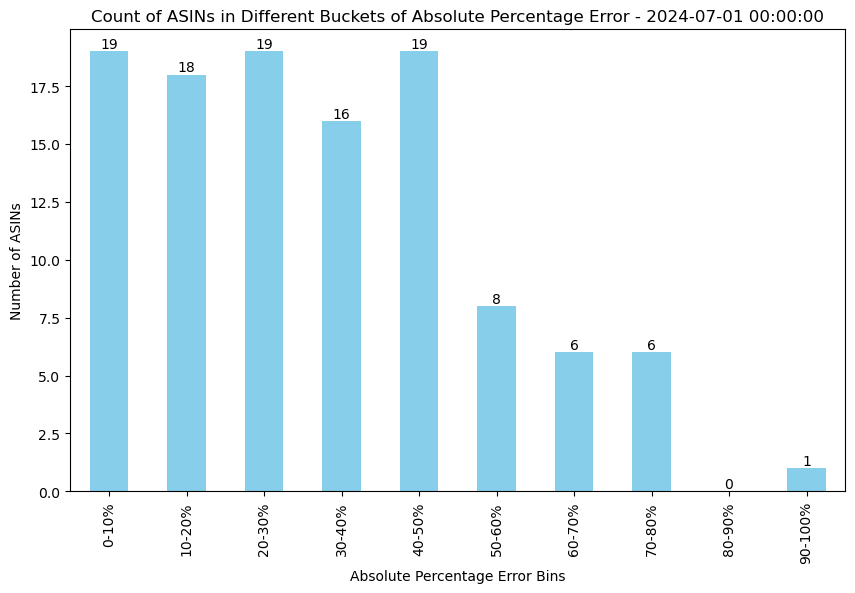

In [136]:
#Graphs with errors distribution
df_fc_ape = df_fc_3

# Define the bins for absolute_percentage_error
bins = [0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70,0.80,0.90, 1.0]
labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']

# Create a new column in df_fc_1 with the binned absolute_percentage_error values
df_fc_ape['error_bin'] = pd.cut(df_fc_ape['absolute_percentage_error'], bins=bins, labels=labels, right=False)

# Count the number of ASINs in each bin
asin_counts = df_fc_ape.groupby('error_bin')['asin'].nunique()

# Extract the year_month value for the title (assuming it's the same for all rows)
year_month = df_fc_ape['year_month'].iloc[0]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
asin_counts.plot(kind='bar', color='skyblue')

# Set plot title and labels
plt.title(f'Count of ASINs in Different Buckets of Absolute Percentage Error - {year_month}')
plt.xlabel('Absolute Percentage Error Bins')
plt.ylabel('Number of ASINs')

# Show the number of ASINs on top of each bar
for index, value in enumerate(asin_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')

# Show the plot
plt.show()
